# Random Forest Modeling

Previously we had used a single decision tree to classify our data, this time around we'll use a random forest.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTENC

from src.seed import SEED
from src.helper import confmat, praf1

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load data, spllt
train = pd.read_csv("../data/processed/train.csv")
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

In [3]:
# account for class imbalance
sm = SMOTENC(np.arange(19, 69), random_state=SEED, n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)

## Baseline Random Forest

We won't perform any tuning of our model other than specifying a random state

In [4]:
# train and predict a random forest model
rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

In [5]:
# output scores
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,1.000000,1.00000,1.0000,1.00000
Testing,0.927273,0.56044,0.9296,0.69863


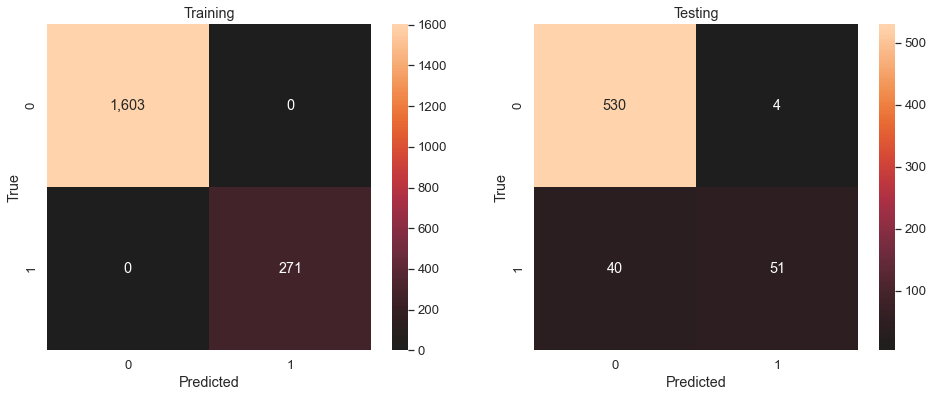

In [6]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

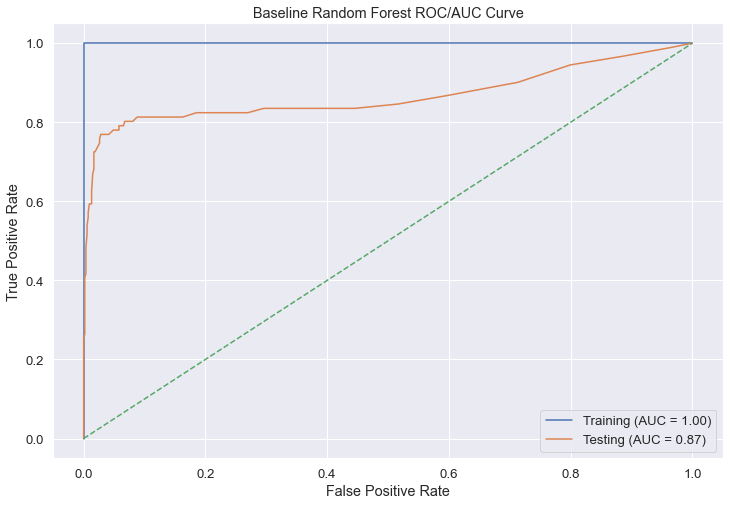

In [7]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rf, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rf, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("Baseline Random Forest ROC/AUC Curve")
plt.show()

This model is definitely interesting, we see in our tests it has an f1 score of .71, with a recall of about .69, and precision of .73, our tests even show an AUC of .86, meaning our model has a good measure of separability. Moving forward we'll aim to increase our auc.

## Hyper Parameter Tuning

Next up is tuning, we'll be looking to increase our performance by optimizing our f1 score. Giving us a balance between precision and recall.

In [8]:
# create param grid, and randomized search
param_grid = {
    "max_depth": np.arange(1, 16),
    "min_samples_leaf": stats.uniform(),
    "max_features": stats.uniform(),
    
}
rs = RandomizedSearchCV(
    RandomForestClassifier(criterion="entropy", random_state=SEED, n_jobs=-1),
    param_grid,
    n_iter=500,
    scoring="f1",
    n_jobs=-1,
    random_state=SEED,
)
rs.fit(X_train, y_train)
print(rs.best_params_)

{'max_depth': 15, 'max_features': 0.9427466840249616, 'min_samples_leaf': 0.005159346813021659}


In [9]:
# predictions and scoring
train_pred = rs.predict(X_train)
test_pred = rs.predict(X_test)

a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.938326,0.785978,0.96158,0.855422
Testing,0.846154,0.725275,0.94080,0.781065


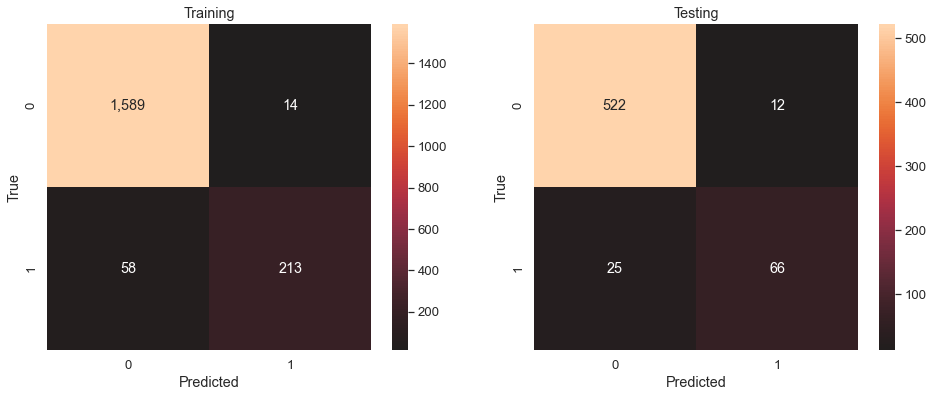

In [10]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

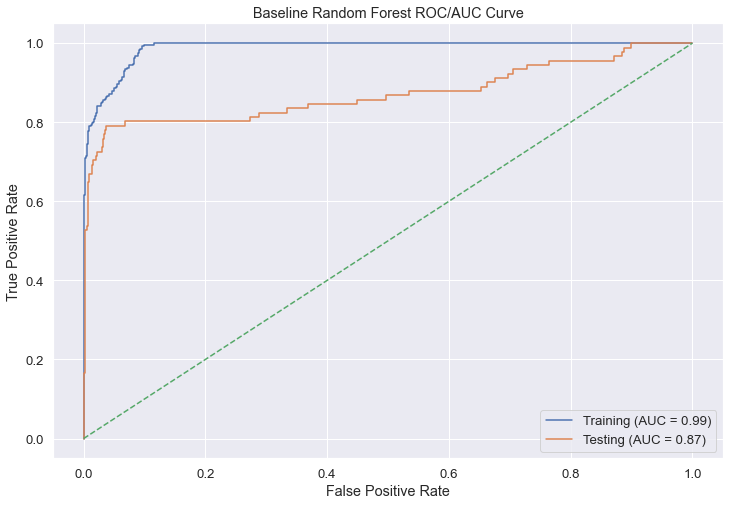

In [11]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rs, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rs, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("Baseline Random Forest ROC/AUC Curve")
plt.show()

After searching through 500 random models, our best one doesn't have a better auc score still at .87, meaning we still differentiate between our classes at the same rate. However, we do see an improvement in accuracy by 2% compared to our baseline model, and our recall has jumped almost 20%. Overall this model is noticeably better, and has less over fitting.